# init

In [1]:
from methods import *

# the numpy arrays need to match the same floating type used by pytorch here
th.set_default_dtype(th.float32)

# remove some annoying tensorflow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# set device to load pytorch models and data onto

# set directory to write all results to
run_path = 'results/init/'
os.makedirs(run_path, exist_ok=True)

# set random seeds for replicability
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
th.manual_seed(random_seed)
if th.cuda.is_available():
    th.cuda.manual_seed_all(random_seed) 

# set file io
save_model_to = f'{run_path}model.pth'
save_evals_to = f'{run_path}evaluations.json'

# harware params
device = 'cuda:1'
pytorch_threads = 16
num_workers = 2
batch_size = 128
pin_memory = False

cpu count: 20
gpu count: 3
cuda avail: True


# prepare training and validation data

In [2]:
# read data
prepared_datasets_path = '/home/tim/Dropbox/data/prepared_datasets/'
X = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/train_rgb.npy')
Y = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/train_depth.npy')

# sample from data
import random
n_train, n_val = 1_000, 1_000
idxs = [i for i in range(len(X))]
random.shuffle(idxs)
X_train = X[idxs[:n_train]]
Y_train = Y[idxs[:n_train]]
if n_val > 0:
    X_val = X[idxs[-1*n_val:]]
    Y_val = Y[idxs[-1*n_val:]]
else:
    X_val = None
    Y_val = None
del X, Y

# extract parameters from input/ouput data
n_instances = X_train.shape[0]
n_channels = X_train.shape[1]
n_dim1 = X_train.shape[2]
n_dim2 = X_train.shape[3]

print('Train shape:', X_train.shape, Y_train.shape)
print('Val shape:', X_val.shape, Y_val.shape)

Train shape: (1000, 3, 144, 256) (1000, 1, 144, 256)
Val shape: (1000, 3, 144, 256) (1000, 1, 144, 256)


# process params

In [3]:
# # calucate statistics to standardize (done during dataloader)

# R = predictor_train[:,0,:,:].flatten()
# G = predictor_train[:,1,:,:].flatten()
# B = predictor_train[:,2,:,:].flatten()

# mean_R, std_R = np.mean(R), np.std(R)
# mean_G, std_G = np.mean(G), np.std(G)
# mean_B, std_B = np.mean(B), np.std(B)

# means = np.array([mean_R, mean_G, mean_B])
# stds = np.array([std_R, std_G, std_B])

In [4]:
X_mean = 94.11807077041952 #np.mean(predictor_train)
X_std = 80.77841523336176 #np.std(predictor_train)
Y_min = 0
Y_max = 255

def x_preproc_func(x, _mean, _std):
    return (x.astype(np.float32)-_mean)/_std
def y_preproc_func(y, _min, _max):
    return (y.astype(np.float32)-_min)/(_max-_min)
x_preproc_params={'_mean':X_mean, '_std':X_std}
y_preproc_params={'_min':Y_min, '_max':Y_max}
def unprocess_func(p, _min, _max):
    p = (p*(_max-_min)+_min).astype(np.uint8)
    p[p==0] = 1
    return p
unprocess_params={'_min':Y_min, '_max':Y_max}

# set model architecture

In [5]:
# make a scalable CNN following Zixia's depth network which is inspired by: https://ieeexplore.ieee.org/abstract/document/9318521
scale = 1
model_func = create_cnn
model_params = {
    'block_layers':[
            [
                [nn.Conv2d, {'in_channels':n_channels, 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(64*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(64*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(128*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(128*scale), 'out_channels':int(256*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':4, 'padding':4}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(256*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(128*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(128*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(64*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(64*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':3, 'padding':1}],
                [nn.SELU],
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(1), 'kernel_size':1, 'stride':1, 'padding':0}],
                [nn.Sigmoid],
            ],
            # [
            #     [nn.Flatten],
            #     [mlp_modules, {
            #         'layers':[n_preds,1024,512,64,n_targets],
            #         'dropout':[0.2,0.2,0.2,0.2,0.2],
            #         'hid_activation':nn.ELU,
            #         'out_activation':nn.Sigmoid,
            #         }],
            # ],
       ]
}

# View model dimensions at each layer

In [6]:
# model = model_func(**model_params).to(device)
# model

# # view dimensions at each layer of network
# print('stride = 2')
# x = th.tensor(X_train[:10].astype(np.float32)).to(device)
# print('input', x.size())
# for m_idx, module in enumerate(model):
#     x = module(x)
#     print('layer', m_idx+1, x.size())

# del model
# del x

# train model

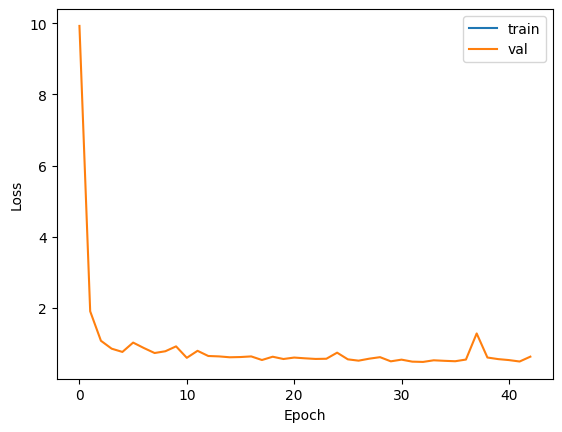

In [7]:
model, train_errors, val_errors, train_times = one_shot(model_func, model_params, run_path, X_train, Y_train, X_val, Y_val,
             optimizier_func=th.optim.Adam, optimizer_params={}, error_func=mean_absolute_percent_error_tensor, minimize_error=True,
             criterion=nn.L1Loss(), patience=10, max_epochs=100, 
             augmentors=None, sample_size=None, device=device, batch_size=batch_size, pytorch_threads=pytorch_threads, num_workers=num_workers, pin_memory=pin_memory,
             checkpoint_freq=0, random_seed=random_seed, mem_optim=True, show_curve=True, show_curve_freq=1,
             x_preproc_func=x_preproc_func, x_preproc_params=x_preproc_params, y_preproc_func=y_preproc_func, y_preproc_params=y_preproc_params,
            )
th.save(model, save_model_to)

# eval model

In [8]:
X_test = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_rgb.npy')
Y_test = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_depth.npy')
num_workers = 4 # change for your GPU (this is set for mlserver2019 gpu)
pytorch_threads = 1 # change for your GPU (this is set for mlserver2019 gpu)
batch_size = 256 # change for your GPU (this is set for mlserver2019 gpu)
P_test, predict_time = predict_model(model, device, X_test, Y_test.shape, x_preproc_func=x_preproc_func, x_preproc_params=x_preproc_params, 
                       batch_size=batch_size, pytorch_threads=pytorch_threads, num_workers=num_workers, pin_memory=False,)
evaluations = {
    'r2':r2_score(Y_test, P_test),
    'mape':mean_absolute_percent_error_numpy(Y_test, P_test),
    'predict_time':predict_time,
    'n_epochs':len(train_times)-1,
    'train_time':np.sum(train_times),
}
del X_test, Y_test, P_test
print(evaluations)
evaluations['train_errors'] = train_errors
evaluations['val_errors'] = val_errors
evaluations['train_times'] = train_times
write_json(evaluations, save_evals_to)

# save_predictions = False
# if save_predictions_to is not None:
#     np.save(save_predictions_to, P_test)

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [4]:
from methods import *

device = 'cuda:1'
run_path = 'results/init/'
save_model_to = f'{run_path}model.pth'
model = th.load(save_model_to)
prepared_datasets_path = '/home/tim/Dropbox/data/prepared_datasets/'
X_test = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_rgb.npy')
Y_test = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_depth.npy')

X_mean = 94.11807077041952 #np.mean(predictor_train)
X_std = 80.77841523336176 #np.std(predictor_train)
Y_min = 0
Y_max = 255
def x_preproc_func(x, _mean, _std):
    return (x.astype(np.float32)-_mean)/_std
def y_preproc_func(y, _min, _max):
    return (y.astype(np.float32)-_min)/(_max-_min)
x_preproc_params={'_mean':X_mean, '_std':X_std}
y_preproc_params={'_min':Y_min, '_max':Y_max}
def unprocess_func(p, _min, _max):
    p = (p*(_max-_min)+_min).astype(np.uint8)
    p[p==0] = 1
    return p
unprocess_params={'_min':Y_min, '_max':Y_max}

times = []
params = []
iter_num = 0
for pytorch_threads in [1,2,3,4]:
    for num_workers in [0,1,2,3,4]:
        for batch_size in [32,64,128,256,512]:
            iter_num += 1
            P_test, predict_time = predict_model(model, device, X_test, Y_test.shape, x_preproc_func=x_preproc_func, x_preproc_params=x_preproc_params, 
                                   batch_size=batch_size, pytorch_threads=pytorch_threads, num_workers=num_workers, pin_memory=False,)
            times.append(predict_time)
            params.append([pytorch_threads, num_workers, batch_size])
            print(predict_time, [pytorch_threads, num_workers, batch_size])

/tmp/ipykernel_3758582/3561144770.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = th.load(save_model_to)


87.02575635910034 [1, 0, 32]
80.79435420036316 [1, 0, 64]
94.37958192825317 [1, 0, 128]
102.3454942703247 [1, 0, 256]
105.3913083076477 [1, 0, 512]
88.3897864818573 [1, 1, 32]
84.17002391815186 [1, 1, 64]
81.23127365112305 [1, 1, 128]
79.90931129455566 [1, 1, 256]
80.04941415786743 [1, 1, 512]
88.76858973503113 [1, 2, 32]
83.2830650806427 [1, 2, 64]
80.47925615310669 [1, 2, 128]
81.12132287025452 [1, 2, 256]
80.51216673851013 [1, 2, 512]
89.38923144340515 [1, 3, 32]
83.93968510627747 [1, 3, 64]
82.64137363433838 [1, 3, 128]
81.56424689292908 [1, 3, 256]
81.19393253326416 [1, 3, 512]
90.06113481521606 [1, 4, 32]
85.06326675415039 [1, 4, 64]
81.99106812477112 [1, 4, 128]
82.13915944099426 [1, 4, 256]
81.85903859138489 [1, 4, 512]
81.57904958724976 [2, 0, 32]
92.10698199272156 [2, 0, 64]
92.95630764961243 [2, 0, 128]
94.98536515235901 [2, 0, 256]
96.61481308937073 [2, 0, 512]
84.52021527290344 [2, 1, 32]
80.34732103347778 [2, 1, 64]
77.20762801170349 [2, 1, 128]
76.9180805683136 [2, 1, 25

In [1]:
from methods import *

device = 'cuda:1'
run_path = 'results/init/'
save_model_to = f'{run_path}model.pth'
model = th.load(save_model_to)
prepared_datasets_path = '/home/tim/Dropbox/data/prepared_datasets/'
X_test = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_rgb.npy')
Y_test = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_depth.npy')

X_mean = 94.11807077041952 #np.mean(predictor_train)
X_std = 80.77841523336176 #np.std(predictor_train)
Y_min = 0
Y_max = 255
def x_preproc_func(x, _mean, _std):
    return (x.astype(np.float32)-_mean)/_std
def y_preproc_func(y, _min, _max):
    return (y.astype(np.float32)-_min)/(_max-_min)
x_preproc_params={'_mean':X_mean, '_std':X_std}
y_preproc_params={'_min':Y_min, '_max':Y_max}
def unprocess_func(p, _min, _max):
    p = (p*(_max-_min)+_min).astype(np.uint8)
    p[p==0] = 1
    return p
unprocess_params={'_min':Y_min, '_max':Y_max}

times = []
params = []
iter_num = 0
for pytorch_threads in [4,8,16]:
    for num_workers in [2,4]:
        for batch_size in [32,64,128]:
            iter_num += 1
            P_test, predict_time = predict_model(model, device, X_test, Y_test.shape, x_preproc_func=x_preproc_func, x_preproc_params=x_preproc_params, 
                                   batch_size=batch_size, pytorch_threads=pytorch_threads, num_workers=num_workers, pin_memory=False,)
            times.append(predict_time)
            params.append([pytorch_threads, num_workers, batch_size])
            print(predict_time, [pytorch_threads, num_workers, batch_size])

cpu count: 20
gpu count: 3
cuda avail: True


/tmp/ipykernel_3814298/4077332401.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = th.load(save_model_to)


79.39739060401917 [4, 2, 32]
77.1992654800415 [4, 2, 64]
76.43604946136475 [4, 2, 128]
82.18567109107971 [4, 4, 32]
78.8837730884552 [4, 4, 64]
76.56700277328491 [4, 4, 128]
81.02194380760193 [8, 2, 32]
77.91586232185364 [8, 2, 64]
75.73925042152405 [8, 2, 128]
81.98846173286438 [8, 4, 32]
78.58818459510803 [8, 4, 64]
76.2318844795227 [8, 4, 128]
80.90027618408203 [16, 2, 32]
78.69657588005066 [16, 2, 64]
75.34801769256592 [16, 2, 128]
81.717618227005 [16, 4, 32]
78.9204797744751 [16, 4, 64]
76.18344497680664 [16, 4, 128]


In [ ]:
# benchmark results [thrads, workers, batch]
87.02575635910034 [1, 0, 32]
80.79435420036316 [1, 0, 64]
94.37958192825317 [1, 0, 128]
102.3454942703247 [1, 0, 256]
105.3913083076477 [1, 0, 512]
88.3897864818573 [1, 1, 32]
84.17002391815186 [1, 1, 64]
81.23127365112305 [1, 1, 128]
79.90931129455566 [1, 1, 256]
80.04941415786743 [1, 1, 512]
88.76858973503113 [1, 2, 32]
83.2830650806427 [1, 2, 64]
80.47925615310669 [1, 2, 128]
81.12132287025452 [1, 2, 256]
80.51216673851013 [1, 2, 512]
89.38923144340515 [1, 3, 32]
83.93968510627747 [1, 3, 64]
82.64137363433838 [1, 3, 128]
81.56424689292908 [1, 3, 256]
81.19393253326416 [1, 3, 512]
90.06113481521606 [1, 4, 32]
85.06326675415039 [1, 4, 64]
81.99106812477112 [1, 4, 128]
82.13915944099426 [1, 4, 256]
81.85903859138489 [1, 4, 512]
81.57904958724976 [2, 0, 32]
92.10698199272156 [2, 0, 64]
92.95630764961243 [2, 0, 128]
94.98536515235901 [2, 0, 256]
96.61481308937073 [2, 0, 512]
84.52021527290344 [2, 1, 32]
80.34732103347778 [2, 1, 64]
77.20762801170349 [2, 1, 128]
76.9180805683136 [2, 1, 256]
76.86290526390076 [2, 1, 512]
84.5081217288971 [2, 2, 32]
80.26342868804932 [2, 2, 64]
77.83106136322021 [2, 2, 128]
76.92691111564636 [2, 2, 256]
77.03885316848755 [2, 2, 512]
84.62639880180359 [2, 3, 32]
81.22449612617493 [2, 3, 64]
77.53788018226624 [2, 3, 128]
76.34599328041077 [2, 3, 256]
76.38631820678711 [2, 3, 512]
84.31427001953125 [2, 4, 32]
80.6886191368103 [2, 4, 64]
77.84603428840637 [2, 4, 128]
77.79468750953674 [2, 4, 256]
77.04109263420105 [2, 4, 512]
76.90882849693298 [3, 0, 32]
84.63456964492798 [3, 0, 64]
86.78765892982483 [3, 0, 128]
91.13319778442383 [3, 0, 256]
91.99920463562012 [3, 0, 512]
82.63835668563843 [3, 1, 32]
78.92034220695496 [3, 1, 64]
76.32929873466492 [3, 1, 128]
75.73552107810974 [3, 1, 256]
75.16042637825012 [3, 1, 512]
83.13539123535156 [3, 2, 32]
79.55741810798645 [3, 2, 64]
76.90571022033691 [3, 2, 128]
76.08216309547424 [3, 2, 256]
75.68615865707397 [3, 2, 512]
82.96511507034302 [3, 3, 32]
79.72368884086609 [3, 3, 64]
77.14316129684448 [3, 3, 128]
76.35018849372864 [3, 3, 256]
76.11453342437744 [3, 3, 512]
83.88033986091614 [3, 4, 32]
80.09963512420654 [3, 4, 64]
76.9735312461853 [3, 4, 128]
76.14249181747437 [3, 4, 256]
76.48806715011597 [3, 4, 512]
76.61690926551819 [4, 0, 32]
82.59971356391907 [4, 0, 64]
85.07032346725464 [4, 0, 128]
88.99526906013489 [4, 0, 256]
90.5530834197998 [4, 0, 512]
82.19019770622253 [4, 1, 32]
78.76677775382996 [4, 1, 64]
75.91229772567749 [4, 1, 128]
75.83945560455322 [4, 1, 256]
75.40162253379822 [4, 1, 512]
82.981773853302 [4, 2, 32]
79.15462040901184 [4, 2, 64]
75.74457120895386 [4, 2, 128]
75.7627341747284 [4, 2, 256]
75.74460792541504 [4, 2, 512]
83.16737413406372 [4, 3, 32]
79.55415987968445 [4, 3, 64]
76.69817686080933 [4, 3, 128]
76.08040452003479 [4, 3, 256]
75.88959383964539 [4, 3, 512]
83.223717212677 [4, 4, 32]
79.54752278327942 [4, 4, 64]
76.80637669563293 [4, 4, 128]
76.36816382408142 [4, 4, 256]
76.13667297363281 [4, 4, 512]

79.39739060401917 [4, 2, 32]
77.1992654800415 [4, 2, 64]
76.43604946136475 [4, 2, 128]
82.18567109107971 [4, 4, 32]
78.8837730884552 [4, 4, 64]
76.56700277328491 [4, 4, 128]
81.02194380760193 [8, 2, 32]
77.91586232185364 [8, 2, 64]
75.73925042152405 [8, 2, 128]
81.98846173286438 [8, 4, 32]
78.58818459510803 [8, 4, 64]
76.2318844795227 [8, 4, 128]
80.90027618408203 [16, 2, 32]
78.69657588005066 [16, 2, 64]
75.34801769256592 [16, 2, 128]
81.717618227005 [16, 4, 32]
78.9204797744751 [16, 4, 64]
76.18344497680664 [16, 4, 128]